In [1]:
#Importing packages
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
#Load IMDB Dataset
train_data, val_data, test_data = tfds.load(
    "imdb_reviews",
    split=("train[:60%]", "train[60%:]", "test"),
    as_supervised=True
)

In [3]:
#Text Vectorization
max_tokens = 10000
sequence_length = 250

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=sequence_length
)

In [4]:
# Fit vectorizer on training data
vectorizer.adapt(train_data.map(lambda x, y: x))

In [21]:
 #Build model
model = tf.keras.Sequential([
    vectorizer,
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16,mask_zero=True),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [31]:
#Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 250, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,769 (643.63 KB)

 Trainable params: 164,769 (643.63 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
#Train model
# First, define the Early Stopping callback (run this before the model.fit block)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Watch the validation loss
    patience=3,                 # Wait 5 epochs for the loss to increase before stopping
    restore_best_weights=True   # Load the weights from the epoch with the lowest val_loss
)
history = model.fit(
    train_data.shuffle(10000).batch(512),
    epochs=100,
    validation_data=val_data.batch(512),
    callbacks=[early_stopping_callback]
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 905ms/step - accuracy: 0.9607 - loss: 0.1264 - val_accuracy: 0.8681 - val_loss: 0.3821
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9610 - loss: 0.1228 - val_accuracy: 0.8694 - val_loss: 0.3829
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9646 - loss: 0.1142 - val_accuracy: 0.8689 - val_loss: 0.3903
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 984ms/step - accuracy: 0.9647 - loss: 0.1147 - val_accuracy: 0.8668 - val_loss: 0.3886


In [33]:
#Evaluation on test data
results = model.evaluate(test_data.batch(512))
print(f"\nTest Loss: {results[0]:.4f}, Test Accuracy: {results[1]*100:.2f}%")

49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.8585 - loss: 0.4064

Test Loss: 0.4064, Test Accuracy: 85.85%


In [36]:
#Prediction on new text
examples = [
    "The movie was amazing! I really loved it.",
    "Worst movie ever. Waste of time.",
    "It is a complete waste of time.",
    "beautiful movie.",
    "fantastic"
]
examples_dataset = tf.data.Dataset.from_tensor_slices(examples).batch(2)

predictions = model.predict(examples_dataset)

for review, score in zip(examples, predictions):
    print(f"Review: {review}")
    print(f"Sentiment score: {score[0]:.3f} ({'Positive' if score[0] > 0.5 else 'Negative'})\n")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Review: The movie was amazing! I really loved it.
Sentiment score: 0.886 (Positive)

Review: Worst movie ever. Waste of time.
Sentiment score: 0.018 (Negative)

Review: It is a complete waste of time.
Sentiment score: 0.111 (Negative)

Review: beautiful movie.
Sentiment score: 0.698 (Positive)

Review: fantastic
Sentiment score: 0.699 (Positive)



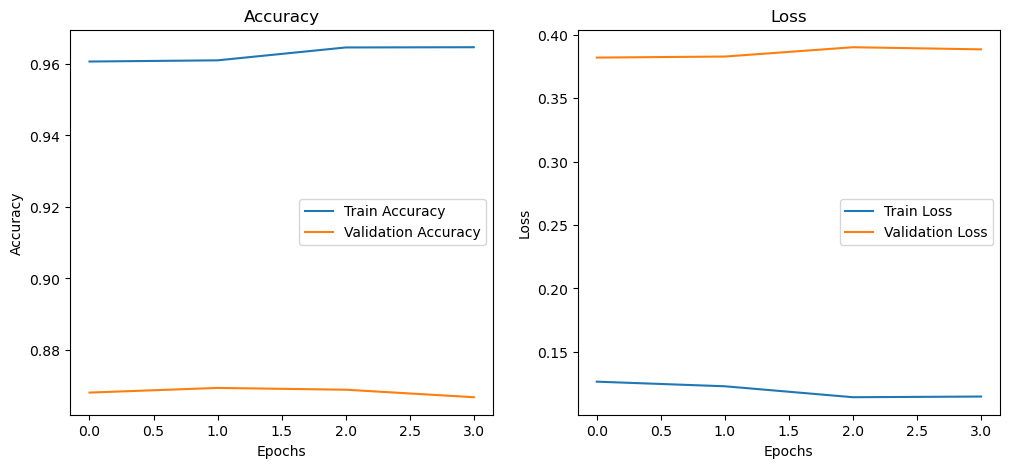

In [35]:
#Visualization of the model
plt.figure(figsize=(12,5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()